# Data Generation for Car Loan Use Case
This notebook reports the steps to generate data folowing custom trends, applied on the Car Loan use case. There are three main parts:
* The first part is to generate data that folows a custom trend in general, including the possibility to specify what % a particular in-/decrease should be.
* The second part is to apply these tools on the Car Loan use case and to generate custom data for all Car Loan widgets.
* The third part is to ingest the data into Lily. The data is visualized in this local environment to have quicker feedback on code changes, but of course has to be ingested into Lily eventually.

# 0. Visualization Tools

These are some preparation tools just for the sake of visualization in this notebook. Basically, we can now aggregate and visualize data, grouped in databins. This part can be skipped.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

In [2]:
databins = ['2016-01-01', '2016-01-15', '2016-02-01', '2016-02-15', '2016-03-01', '2016-03-15',
            '2016-04-01', '2016-04-15', '2016-05-01', '2016-05-15', '2016-06-01', '2016-06-15',
            '2016-07-01', '2016-07-15', '2016-08-01', '2016-08-15', '2016-09-01', '2016-09-15',
            '2016-10-01', '2016-10-15', '2016-11-01', '2016-11-15', '2016-12-01']
databinsZ = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
            '2016-01-01', '2017-01-01']
databinsF = ['2016-11-30', '2017-11-30', '2018-11-30', '2019-11-30', '2020-11-30', '2021-11-30',
            '2022-11-30', '2023-11-30']
ticks = ('1/16', '2/16', '3/16', '4/16', '5/16', '6/16', '7/16', '8/16', '9/16', '10/16', '11/16', '12/16')

In [102]:
def createBins(df, databins, column='START_DATE', cumulative=True):
    if cumulative:
        return np.array([len(df[df.loc[:,column] < databins[i]]) for i in range(len(databins)-1)], dtype=float)
    return np.array([len(df[(df.END_DATE > databins[i]) & (df.END_DATE < databins[i+1])]) for i in range(len(databins)-1)])

# 1. Data Generation Tools
This part is about generating data that folows a custom trend in general. When the needed trend is constant, or increasing or decreasing in a consistent manner, this can be solved quite easily. When a more complex trend is needed, however, it is convenient to provide a function that accounts for any particularities in that trend.

### 1.1 Create Functions
These are four arbitrary functions for the sake of demonstration, visualized below.

In [4]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def peak(x):
    xPoints = (np.array([-6*365, 0, 1, 150, 180, 210, 365]) + 6*365) / (7*365.)
    yPoints = np.array([0, 2, 2, 2, 50, 2, 2]) / 50.
    i = interp1d(xPoints, yPoints)
    return i(x)

functions = [logit, gauss, winner, peak]

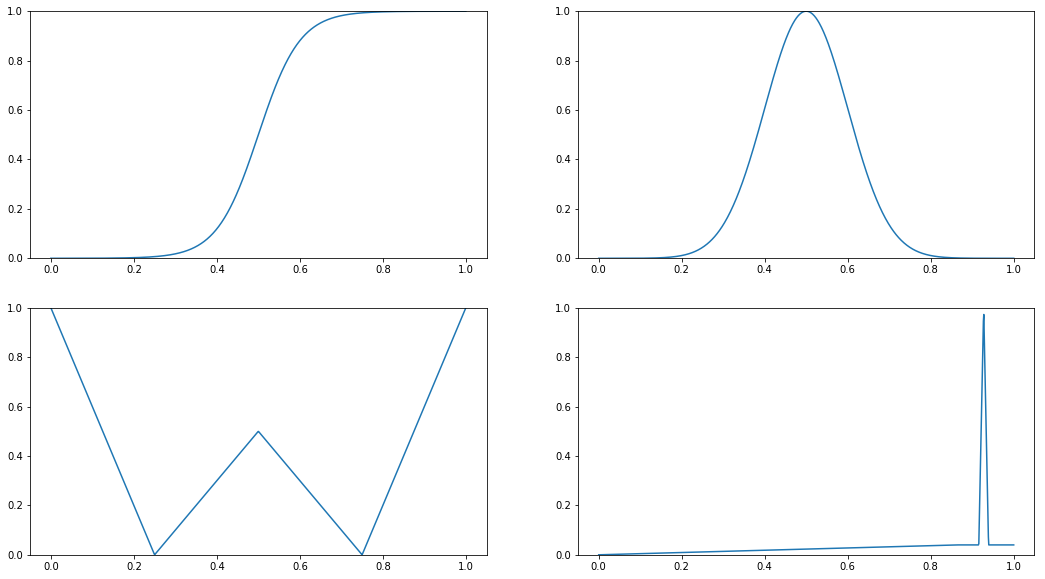

In [5]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i)
    ax.plot(x, f(x))
    plt.ylim(0,1)
plt.show()

### 1.2 Create Distributions

Here, 10000 random numbers are generated for every function. When plotted in a histogram, their distributions clearly folow the respective functions. The take-away message here is that any trend should be describable.

In [6]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

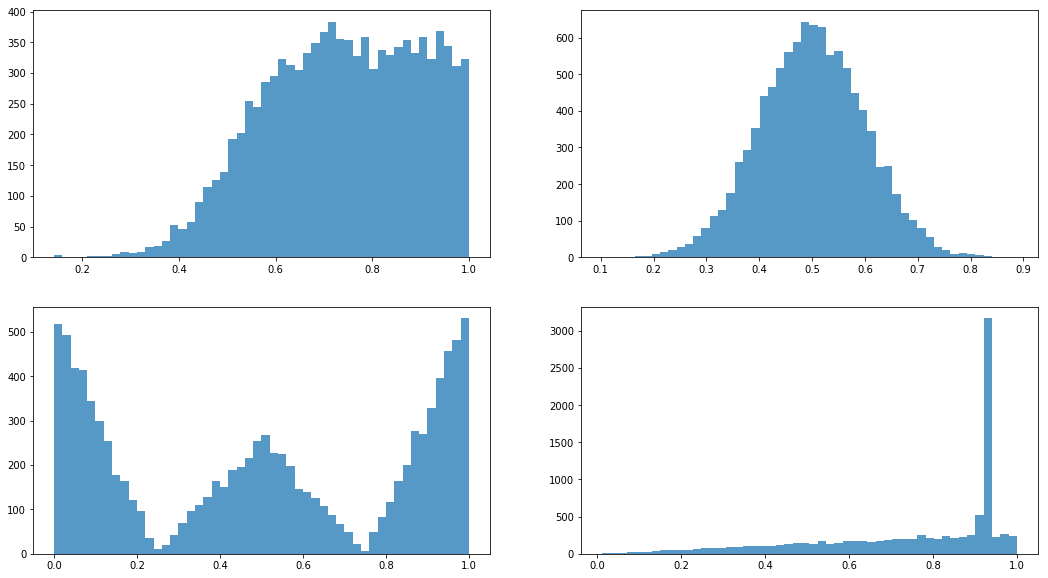

In [7]:
fig, axs = plt.subplots(2,2, figsize=(18, 10))
for i, (f, ax) in enumerate(zip(functions, axs.flatten())):
    picks = generateDistribution(f, 10000)
    ax.hist(picks, bins=50, alpha=0.75)
plt.show()

### 1.3 Retrieve Percentage of Increase
With respect to a use case, it would be convenient to play around with percentages by which a trend should increase or decrease for a specified period of time. Eg. a 30% increase of the clients' volume in 2016. Say we have a trend as folows, with the distribution shown cumulatively.

In [8]:
xPoints = (np.arange(5) / 4.)
yPoints = np.array([0, 50, 0, 20, 0]) / 50.
i = interp1d(xPoints, yPoints)

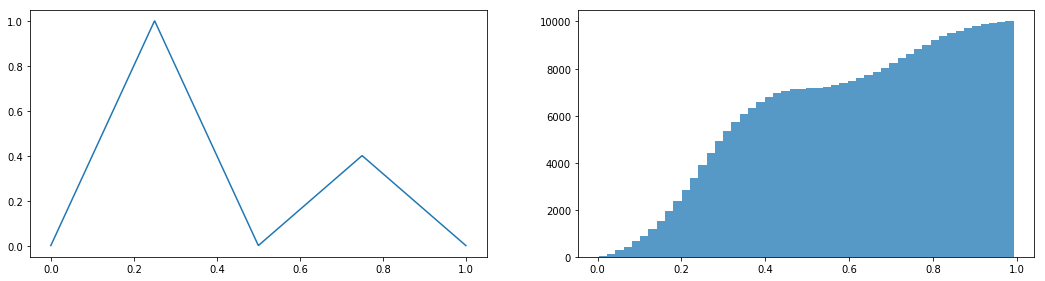

In [9]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax1.plot(x, i(x))
picks = generateDistribution(i, 10000)
ax2 = fig.add_subplot(222)
ax2.hist(picks, bins=50, alpha=0.75, cumulative=True)
plt.show()

Then by means of integrals we can calculate what the percentage is of the first large increase.

In [10]:
from scipy.integrate import quad
def percentageIncrease(function, start=0, end=1):
    totalSurface = quad(function, 0., 1.)[0]
    periodSurface = quad(function, start, end)[0]
    return periodSurface / totalSurface

In [11]:
print(percentageIncrease(i))
print(percentageIncrease(i, 0, .5))
print(percentageIncrease(i, .5, 1))

1.0
0.714285714286
0.285714285714


So the first increase in the trend is accountible for about 71% of the data. We can verify in the plot that is just about the case.

### 1.4 Add Random Noise

Generally, trends do not follow straight lines. To account for this, some random jitter should be added, as illustrated below.

In [12]:
def noise(x, c=1):
    n = np.random.randint(5, 20)
    r = [np.random.randint(20, 80) for _ in range(n*2)]
    jitter = 0
    for i in range(n):
        jitter += np.sin(r[i]*x) / float(r[i+1])
    return c * jitter

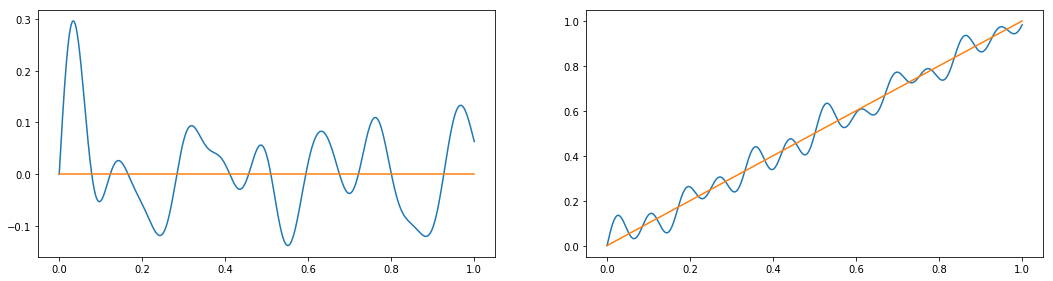

In [13]:
x = np.linspace(0,1, num=1001)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(x, noise(x), x, np.zeros(len(x)))
ax2.plot(x, x+noise(x), x, x)
plt.show()

# 2. Car Loan Data Generation - Entities
The goal is now to apply these building stones on the car loan use case. A configuration of Lily contains scripts to generate the data, and will now contain some of the code above. Below, the data is loaded to verify its trends, and to tweak the scripts if necessary.

In [84]:
path = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/EntityDataAll.hdr'
names = pd.read_csv(path, sep=';')

path = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/EntityDataAll.csv'
productData = pd.read_csv(path, sep=';', index_col=0, names=names.columns)

In [85]:
productData.head()

,customer_id,name,VALUE,START_DATE,END_DATE,CATEGORY,SUB_CATEGORY,ACTIVE,MARGIN,RATE,CREDIT
customer_product_id,,,,,,,,,,,
1000001001,1,Checking Account,5039.308208,2016-06-29,2026-06-27,Checking Account,NaN,True,NaN,NaN,NaN
2000001001,1,Credit Card,NaN,2016-06-25,2026-06-23,Credit Card,NaN,True,NaN,NaN,NaN
4000001001,1,Savings Account,644524.388968,2013-05-12,2023-05-10,Savings Account,NaN,True,NaN,NaN,NaN
5000001001,1,Mutual Funds,12356.418741,2016-09-07,2026-09-05,Mutual Funds,NaN,True,NaN,NaN,NaN
6000001001,1,Bond Products,20213.235453,2012-11-19,2022-11-17,Bond Products,NaN,True,NaN,NaN,NaN


Here, some records are shown for illustration.

In [86]:
productData.loc[:,'START_DATE'] = productData.START_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
productData.loc[:,'END_DATE'] = productData.END_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
print(len(productData))
productData.head()

231424


,customer_id,name,VALUE,START_DATE,END_DATE,CATEGORY,SUB_CATEGORY,ACTIVE,MARGIN,RATE,CREDIT
customer_product_id,,,,,,,,,,,
1000001001,1,Checking Account,5039.308208,2016-06-29,2026-06-27,Checking Account,NaN,True,NaN,NaN,NaN
2000001001,1,Credit Card,NaN,2016-06-25,2026-06-23,Credit Card,NaN,True,NaN,NaN,NaN
4000001001,1,Savings Account,644524.388968,2013-05-12,2023-05-10,Savings Account,NaN,True,NaN,NaN,NaN
5000001001,1,Mutual Funds,12356.418741,2016-09-07,2026-09-05,Mutual Funds,NaN,True,NaN,NaN,NaN
6000001001,1,Bond Products,20213.235453,2012-11-19,2022-11-17,Bond Products,NaN,True,NaN,NaN,NaN


In [87]:
activeCarLoans = productData[productData.name == 'Car Loan']
print(len(activeCarLoans))
activeCarLoans.tail()

13397


,customer_id,name,VALUE,START_DATE,END_DATE,CATEGORY,SUB_CATEGORY,ACTIVE,MARGIN,RATE,CREDIT
customer_product_id,,,,,,,,,,,
15049986001,49986,Car Loan,30592.989733,2010-06-03,2018-05-22,Car Loan,NaN,True,3.550895,5.455850,25322.471855
15049987001,49987,Car Loan,31679.266780,2010-05-18,2021-11-12,Car Loan,NaN,True,3.751091,5.709215,24743.244294
15049994001,49994,Car Loan,35186.072272,2016-12-26,2017-06-12,Car Loan,NaN,True,2.818811,4.537538,29703.113717
15049996001,49996,Car Loan,31909.977623,2014-01-01,2022-11-07,Car Loan,NaN,True,2.869236,4.491341,26877.587077
15049997001,49997,Car Loan,31399.722223,2012-02-27,2019-06-07,Car Loan,NaN,True,3.012317,5.391782,26007.609366


In [106]:
activeCarLoans[activeCarLoans.customer_id==27449]

,customer_id,name,VALUE,START_DATE,END_DATE,CATEGORY,SUB_CATEGORY,ACTIVE,MARGIN,RATE,CREDIT
customer_product_id,,,,,,,,,,,
15027449001,27449,Car Loan,35031.427657,2016-11-18,2017-07-21,Car Loan,NaN,True,3.06696,4.137344,30204.214443


## 2.1 Widget 1: Car Loans & Savings Accounts Share of Wallet

In [88]:
activeCarLoans = productData[productData.name == 'Car Loan']
activeAccounts = productData[productData.name == 'Savings Account']
activeCustomers = productData[productData.groupby(['customer_id'])['START_DATE'].transform(min) == productData['START_DATE']]

In [89]:
carLoansInTime = createBins(activeCarLoans, databins)
accountsInTime = createBins(activeAccounts, databins)
activesInTime = createBins(activeCustomers, databins)

In [90]:
carLoansShare = carLoansInTime / activesInTime
accountsShare = accountsInTime / activesInTime

The plots below show the car loans, savings accounts and active customers over time (left) and the share of car loans and savings accounts (right).

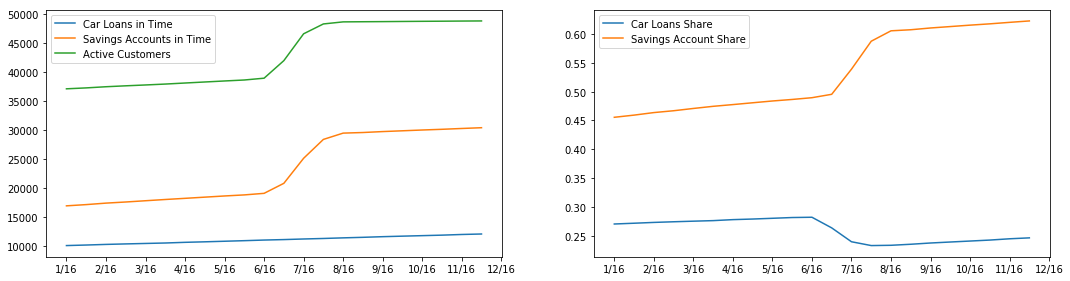

In [91]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, carLoansInTime, label='Car Loans in Time')
ax1.plot(x, accountsInTime, label='Savings Accounts in Time')
ax1.plot(x, activesInTime, label='Active Customers')
ax2.plot(x, carLoansShare, label='Car Loans Share')
ax2.plot(x, accountsShare, label='Savings Account Share')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
ax1.legend(); ax2.legend()
plt.show()

These are the percentage checks.

In [92]:
print 'Increase of total active customers in 2016. Should be 30%:', activesInTime[-1] / float(activesInTime[0])-1
print 'Car Loans Share of Wallets pre 2016. Should be 30%:', carLoansInTime[0] / float(activesInTime[0])
print 'Car Loans Share of Wallets post 2016. Should be 25%:', carLoansInTime[-1] / float(activesInTime[-1])
print 'Savings Accounts Share of Wallets pre 2016. Should be 50%:', accountsInTime[0] / float(activesInTime[0])
print 'Savings Accounts Share of Wallets post 2016. Should be 61%:', accountsInTime[-1] / float(activesInTime[-1])

Increase of total active customers in 2016. Should be 30%: 0.315890064336
Car Loans Share of Wallets pre 2016. Should be 30%: 0.270505262591
Car Loans Share of Wallets post 2016. Should be 25%: 0.246481466328
Savings Accounts Share of Wallets pre 2016. Should be 50%: 0.455409297693
Savings Accounts Share of Wallets post 2016. Should be 61%: 0.622371328042


## 2.2 Widget 2: Evolution of Rate and Margin
The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [93]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 0, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([5.5, 5.5, 4, 4.5])
yPoints2 = np.array([3.5, 3.5, 2.5, 3])
rate = interp1d(xPoints, yPoints1)
margin = interp1d(xPoints, yPoints2)

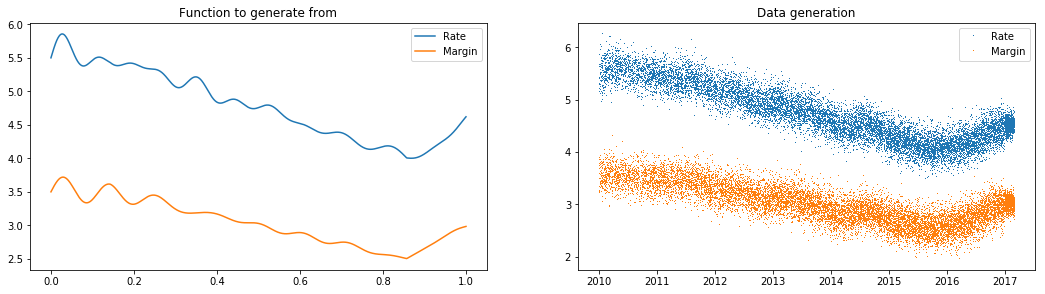

In [94]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, rate(x) + noise(x), label='Rate'); ax1.plot(x, margin(x) + noise(x), label='Margin')
ax2.plot(activeCarLoans.START_DATE, activeCarLoans.RATE, ',', label='Rate')
ax2.plot(activeCarLoans.START_DATE, activeCarLoans.MARGIN, ',', label='Margin')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

## Dataframe test

In [135]:
path = '/Users/desiredewaele/Desktop/names.csv'
names = pd.read_csv(path, sep='|')

path = '/Users/desiredewaele/Desktop/dataframe.csv'
df = pd.read_csv(path, sep='|', index_col=0, names=names.name)

In [175]:
print len(activeCarLoans)
activeCarLoans[['customer_id', 'CREDIT', 'VALUE', 'MARGIN', 'RATE']].head(10)

13397


,customer_id,CREDIT,VALUE,MARGIN,RATE
customer_product_id,,,,,
15000002001,2,27338.473451,33778.139993,2.506446,4.266551
15000010001,10,28312.387226,33400.823068,2.089346,4.145834
15000011001,11,27882.477901,34197.300975,2.623629,4.354013
15000015001,15,29778.882829,34278.807019,2.749605,4.525171
15000020001,20,29752.028926,34252.359551,3.136173,4.251716
15000020002,20,29921.624633,35380.804191,3.048912,4.356501
15000030001,30,27045.934765,32776.509257,2.755738,4.312944
15000034001,34,28657.105051,33981.087612,2.857983,4.146619
15000036001,36,30192.772646,34538.485980,2.888691,4.202754


In [168]:
print (len(df))
df.sort_values('crmId')[['crmId', 'creditCarLoans', 'valueCarLoans', 'marginCarLoans', 'rateCarLoans']].head(10)

12053


,crmId,creditCarLoans,valueCarLoans,marginCarLoans,rateCarLoans
ID,,,,,
-875958446799932586,2,27338.473451,33778.139993,2.506446,4.266551
3926518134270481330,10,28312.387226,33400.823068,2.089346,4.145834
-4752763954226797967,11,27882.477901,34197.300975,2.623629,4.354013
7977535775394194666,15,29779.015790,34278.939981,2.749675,4.525241
-6481560418899972380,20,29752.028926,34252.359551,3.136173,4.251716
-7613458730804338948,30,27046.197267,32776.771759,2.755771,4.312965
-8699555300849131268,34,28657.186868,33981.169429,2.857955,4.146580
2314643759030873165,36,30192.828407,34538.541742,2.888735,4.202797
2335618624435862753,38,26303.946435,31469.648748,3.221579,5.008863


## 2.3 Widget 3: Evolution of Value and Credit

The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [95]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([30000, 30000, 35000])
yPoints2 = np.array([25000, 25000, 30000])
value = interp1d(xPoints, yPoints1)
credit = interp1d(xPoints, yPoints2)

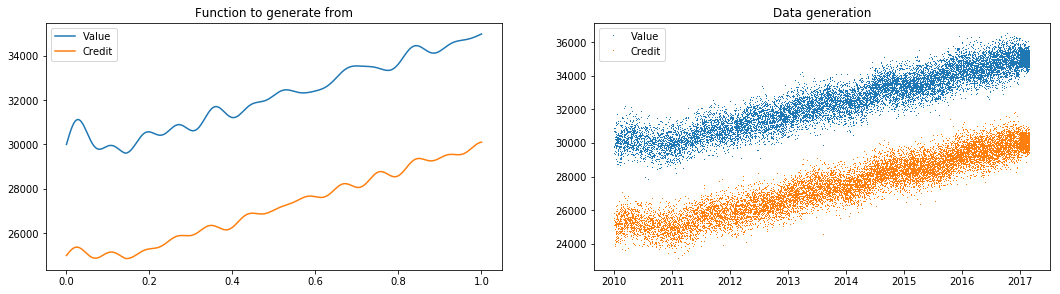

In [99]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, value(x) + noise(x, 3000), label='Value'); ax1.plot(x, credit(x) + noise(x, 3000), label='Credit')
ax2.plot(activeCarLoans.START_DATE, activeCarLoans.VALUE, ',', label='Value')
ax2.plot(activeCarLoans.START_DATE, activeCarLoans.CREDIT, ',', label='Credit')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

In [122]:
activeCarLoans.RATE.mean()

4.666394134560055

## 2.4 Widget 4: Age Buckets of Car Loans

The pie chart below shows the remaining car loan durations. 

In [100]:
def endDate():
    years = np.random.choice(np.arange(7), p=np.array([23, 25, 17, 12, 13, 6, 4]) / 100.)
    return (years + np.random.uniform()) * 365
picks = np.array([endDate() for _ in range(50000)])

In [103]:
carLoansInFuture = createBins(activeCarLoans, databinsF, cumulative=False)
print carLoansInFuture

[2955 3223 2253 1682 1687  902  629]


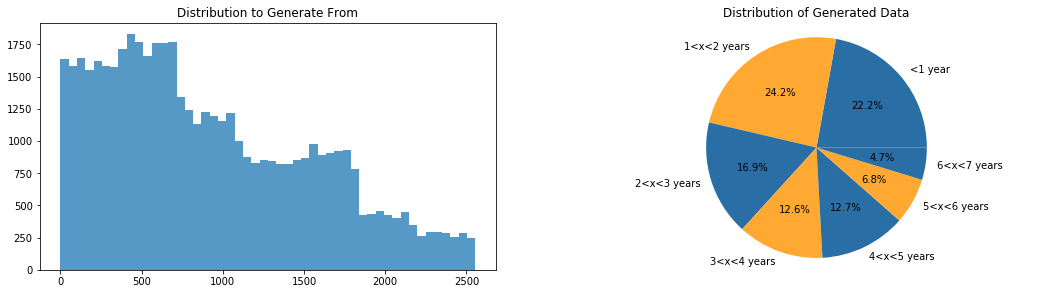

In [104]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.hist(picks, bins=50, alpha=0.75, cumulative=False)
ax1.set_title('Distribution to Generate From')

labels = '<1 year', '1<x<2 years', '2<x<3 years', '3<x<4 years', '4<x<5 years', '5<x<6 years', '6<x<7 years'
ax2.pie(carLoansInFuture, labels=labels, colors=('#2A6EA6', '#FFA933'), autopct='%1.1f%%')
ax2.axis('equal'); ax2.set_title('Distribution of Generated Data')
plt.show()

# 3. Car Loan Data Generation - Interactions

## 3.1 Carflow Interactions

Below, some of the interactions (approved car loans) are shown for illustration.

In [176]:
def striptime(x):
    try:
        return datetime.strptime(x, '%H:%M:%S.%f').time()
    except:
        return datetime.strptime(x, '%H:%M:%S').time()

In [177]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
#basepath = '/Users/desiredewaele/downloads/'
clfile = 'ItxData_CarFlow_2016-11-14_2017-05-14.csv'
names = pd.read_csv(basepath+'ItxData_CarFlow_2016-11-14_2017-05-14.hdr', sep=';')
carloans = pd.read_csv(basepath+clfile, sep=';', names=names)
carloans.loc[:,'date'] = carloans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
carloans.loc[:,'time'] = carloans.time.apply(lambda x: striptime(x))
carloans['dayOfYear'] = carloans.date.map(lambda x: int(x.strftime('%j')) - 1)

In [178]:
print(len(carloans))
carloans.head()

40704


,id,date,time,goal,subgoal,channel,simulationType,simulationLoanAmount,simulationDownPayment,simulationMonthlyPayment,simulationPaymentRate,simulationDuration,simulationTradeInValue,simulationCashRebate,currentPageId,bannerId,successDef,dayOfYear
0,2,2014-12-05,08:47:16.940332,request information,start approval,branch,car loan,61853,443,689,4,58,3000,0,NaN,NaN,NaN,338
1,2,2014-12-10,17:33:20.770026,request information,approval,branch,car loan,51863,492,734,2,50,3000,0,NaN,NaN,car loan sale,343
2,3,2016-08-17,15:50:34.562811,request information,start approval,branch,car loan,44793,450,452,2,56,3000,0,NaN,NaN,NaN,229
3,3,2016-08-22,08:01:10.438324,request information,car loan rejection,web,car loan,63720,521,436,3,58,3000,0,NaN,NaN,NaN,234
4,5,2017-01-28,11:49:01.466697,request information,start approval,call center,car loan,70953,727,799,3,51,3000,0,NaN,Banner E & A,NaN,27


In [179]:
carloans[carloans.id==27449]

,id,date,time,goal,subgoal,channel,simulationType,simulationLoanAmount,simulationDownPayment,simulationMonthlyPayment,simulationPaymentRate,simulationDuration,simulationTradeInValue,simulationCashRebate,currentPageId,bannerId,successDef,dayOfYear
22433,27449,2016-11-12,07:29:57.709984,request information,start approval,branch,car loan,71094,734,616,4,54,3000,0,NaN,NaN,NaN,316
22434,27449,2016-11-17,17:32:25.004727,request information,approval,branch,car loan,48774,510,515,2,58,3000,0,NaN,NaN,car loan sale,321


In [180]:
approvals = carloans[carloans.successDef == 'car loan sale']
rejections = carloans[carloans.subgoal == 'car loan rejection']
complaints = carloans[carloans.subgoal == 'car loan complaint']

In [181]:
def timestamp(x):
    gauss1 = gauss(x, position = 1 / 3., deviation = 0.05, height = 0, altitude = 1)
    gauss2 = gauss(x, position = 0.5, deviation = 0.25, height = 0, altitude = 1.1)
    return (gauss1 + gauss2) / 1.9

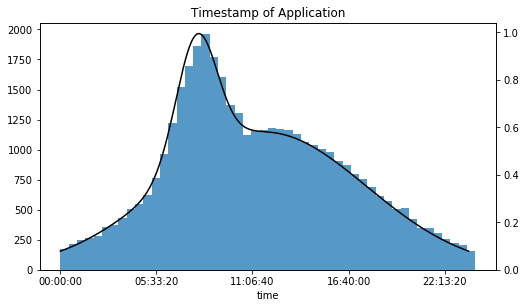

In [182]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax4.plot(x*85000, timestamp(x), '-k')
ax3.hist(carloans.time.values, bins=50, alpha=0.75)

ax3.set_title('Timestamp of Application')
ax4.set_ylim(0,)
plt.show()

In [183]:
precampaign = approvals[approvals.date < '2017']
postcampaign = approvals[approvals.date >= '2017']
print len(precampaign)
print len(postcampaign)

12501
1753


The plots below show the functions to generate the channels from, and the actual generated data. Because the numbers are relatively low, the data does not follow the functions too well on first sight.

In [28]:
def channelFunction(x):
    return [logit(x, 0.5, -200, 0.70, -0.10),
            logit(x, 0.5, -200, 0.25, 0.05),
            logit(x, 0.5, -200, 0.05, 0.05)]

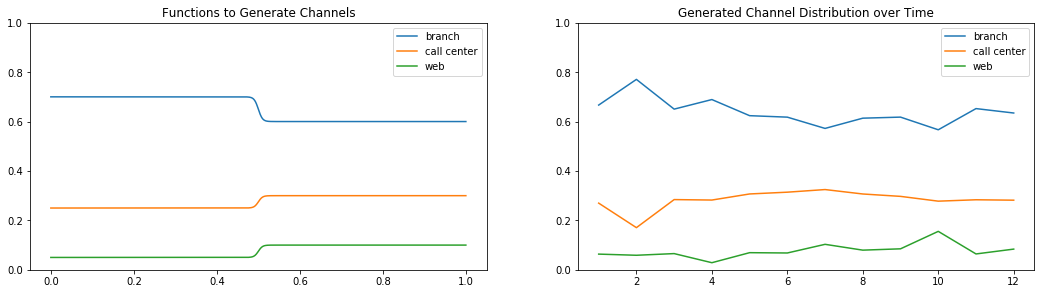

In [29]:
channels = ['branch', 'call center', 'web']
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax1.set_ylim(0,1)
ax2 = fig.add_subplot(222); ax2.set_ylim(0,1)
xPoints1 = np.linspace(0, 1, num=1000)
xPoints2 = np.arange(1, 13, dtype=float)
channelValues = dict()
for i, c in enumerate(channels):
    ax1.plot(xPoints1, channelFunction(xPoints1)[i], label=c)
    channelValues[c] = [np.mean(precampaign[precampaign.date.map(lambda x: x.month == m and x.year == 2016)].channel==c) for m in range(1, 13)]
    ax2.plot(xPoints2, channelValues[c], label=c)
ax1.set_title('Functions to Generate Channels')
ax2.set_title('Generated Channel Distribution over Time')
ax1.legend(); ax2.legend(); plt.show()

However, if we take the mean of channel values in the first five months and the last five months, we can see in the pie charts below that the percentages approach the numbers asked for.

In [30]:
pre = [np.mean(channelValues['branch'][:5]),
       np.mean(channelValues['call center'][:5]),
       np.mean(channelValues['web'][:5])]
post = [np.mean(channelValues['branch'][7:]), 
        np.mean(channelValues['call center'][7:]),
        np.mean(channelValues['web'][7:])]

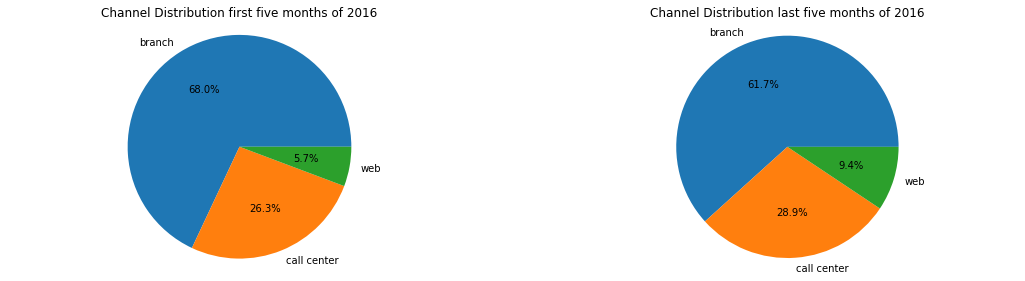

In [31]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(pre, labels=channels, autopct='%1.1f%%')
ax2.pie(post, labels=channels, autopct='%1.1f%%')
ax1.set_title('Channel Distribution first five months of 2016')
ax2.set_title('Channel Distribution last five months of 2016')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

Post-campaign

In [32]:
print np.mean(postcampaign.channel == 'branch')
print np.mean(postcampaign.channel == 'call center')
print np.mean(postcampaign.channel == 'web')

0.608615384615
0.300307692308
0.0910769230769


### Rejections

In [33]:
approvals = createBins(approvals, databins, 'date')
rejections = createBins(rejections, databins, 'date')
complaints = createBins(complaints, databins, 'date')
applications = approvals + rejections

In [34]:
rejectionsShare = rejections / applications
approvalShare = approvals / applications
complaintsShare = complaints / applications

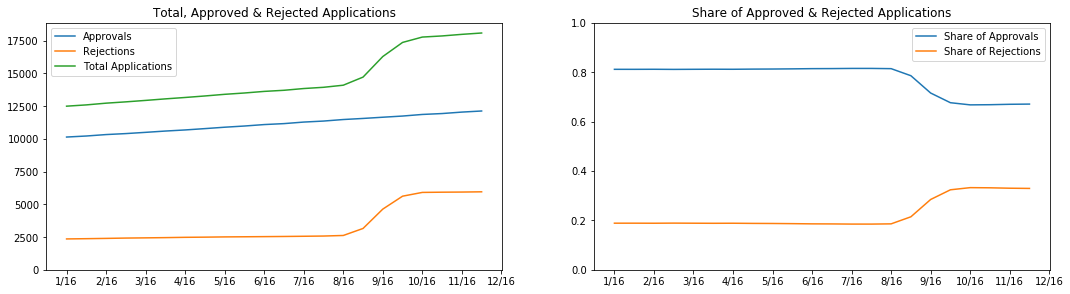

In [35]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, approvals, label='Approvals')
ax1.plot(x, rejections, label='Rejections')
ax1.plot(x, applications, label = 'Total Applications')
ax2.plot(x, approvalShare, label='Share of Approvals')
ax2.plot(x, rejectionsShare, label='Share of Rejections')
ax1.set_title('Total, Approved & Rejected Applications')
ax2.set_title('Share of Approved & Rejected Applications')
ax1.legend(); ax2.legend(); ax1.set_ylim(0,); ax2.set_ylim(0,1)
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

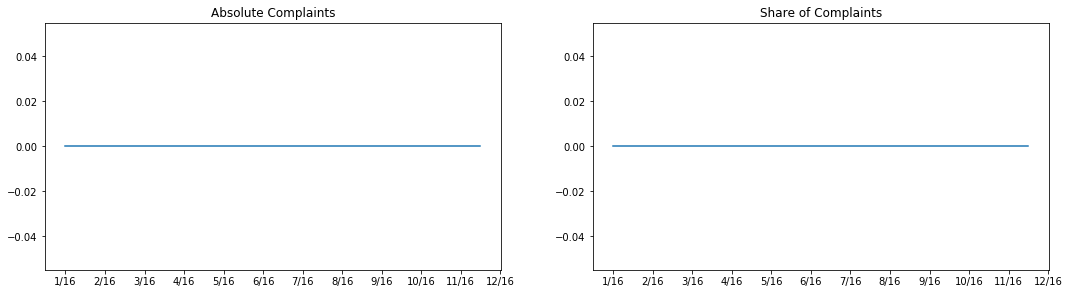

In [36]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, complaints); ax2.plot(x, complaintsShare)
ax1.set_title('Absolute Complaints'); ax2.set_title('Share of Complaints')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

## 3.2 Digital Interactions - Page Visits

Below, some of the digital interactions are shown for illustration.

In [37]:
pagfile = 'ItxData_CarContentWeb_2016-10-30_2017-04-30.csv'
names = pd.read_csv(basepath+'ItxData_CarContentWeb_2016-10-30_2017-04-30.hdr', sep=';')
pag = pd.read_csv(basepath+pagfile, sep=';', names=names)
pag.loc[:,'date'] = pag.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
pag.loc[:,'time'] = pag.time.apply(lambda x: striptime(x))
pag['dayOfYear'] = pag.date.map(lambda x: int(x.strftime('%j')) - 1)

In [38]:
print(len(pag))
pag.sort_values('bannerId', ascending=True).head()

352894


,id,date,time,goal,subgoal,channel,currentPageId,bannerId,action,contrToSuccessDefs,dayOfYear
21,5,2017-01-31,16:24:37.866297,consume content,consume general content,web,car loan-home pagepost,Banner A,show,car loan sale,30
149258,21082,2017-02-13,17:27:17.721409,consume content,consume general content,web,car loan-home pagepost,Banner A,show,car loan sale,43
149418,21104,2017-01-29,04:32:12.084436,consume content,consume general content,web,car loan-home pagepost,Banner A,show,car loan sale,28
149419,21104,2017-01-30,04:32:12.084436,consume content,consume general content,web,car loan-home pagepost,Banner A,show,car loan sale,29
149420,21104,2017-02-01,04:32:12.084436,consume content,consume general content,web,car loan-home pagepost,Banner A,show,car loan sale,31


In [39]:
prepag = pag[pag.date < '2017']
postpag = pag[pag.date >= '2017']
print len(prepag)
print len(postpag)

318139
34755


## 3.3 Digital Interactions - Simulations

In [40]:
simfile = 'ItxData_CarSimWeb_2016-10-30_2017-04-30.csv'
names = pd.read_csv(basepath+'ItxData_CarSimWeb_2016-10-30_2017-04-30.hdr', sep=';')
sim = pd.read_csv(basepath+simfile, sep=';', names=names)
sim.loc[:,'date'] = sim.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
sim.loc[:,'time'] = sim.time.apply(lambda x: striptime(x))
sim['dayOfYear'] = sim.date.map(lambda x: int(x.strftime('%j')) - 1)

In [41]:
print(len(sim))
sim.sort_values('date', ascending=False).head()

26258


,id,date,time,goal,subgoal,channel,simulationType,simulationLoanAmount,simulationDownPayment,simulationMonthlyPayment,simulationPaymentRate,simulationDuration,simulationTradeInValue,simulationCashRebate,currentPageId,bannerId,contrToSuccessDefs,dayOfYear
23035,43830,2017-02-28,23:47:00.274113,request information,run simulation,web,car loan,68647,405,485,4,46,3000,0,simulation,Banner G & C(B),car loan sale,58
379,703,2017-02-27,13:03:16.757162,request information,run simulation,web,car loan,40277,737,563,2,46,3000,0,simulation,Banner F & A,car loan sale,57
17074,32548,2017-02-27,07:12:20.039404,request information,run simulation,web,car loan,54014,538,677,2,57,3000,0,simulation,Banner G & C(A),car loan sale,57
21382,40690,2017-02-26,08:55:36.642954,request information,run simulation,web,car loan,60465,746,495,3,40,3000,0,simulation,Banner G & C(B),car loan sale,56
9319,17857,2017-02-25,10:29:39.295955,request information,run simulation,web,car loan,48340,473,558,2,50,3000,0,simulation,Banner G & C(B),car loan sale,55


In [42]:
presim = sim[sim.date < '2017']
postsim = sim[sim.date >= '2017']
print(len(presim))
print(len(postsim))

24775
1483


### Page Visit and Simulation Evolution

In [43]:
def numberOfPageVisits(x):
    return logit(x, position=0.65, spread=-20, setoff=20, altitude=10)

def numberOfSimulations(x):
    return logit(x, position=0.65, spread=-20, setoff=2, altitude=1)

def numberOfNonCarLoaners(x):
    return logit(x, position=0.65, spread=-20, setoff=85, altitude=180)

def numberOfTotalDigitals(x):
    return numberOfPageVisits(x) + numberOfSimulations(x) + numberOfNonCarLoaners(x)

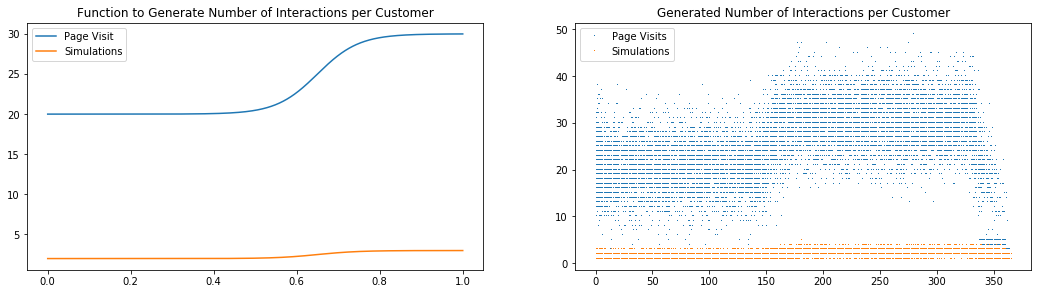

In [44]:
fig = plt.figure(figsize=(18, 10))
x = np.linspace(0, 1, num=1000)
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfPageVisits(x), label = 'Page Visit')
ax1.plot(x, numberOfSimulations(x), label = 'Simulations')
ax2.plot(prepag.groupby(['id'])['dayOfYear'].min(), prepag.groupby(['id']).size(), ',', label='Page Visits')
ax2.plot(presim.groupby(['id'])['dayOfYear'].min(), presim.groupby(['id']).size(), ',', label='Simulations')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Number of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

### Simulation Distribution

In [45]:
simN = presim.groupby(['id']).size()
percentages = []
percentages.append(np.mean(simN == 1))
percentages.append(np.mean(simN == 2))
percentages.append(np.mean(simN == 3))
percentages.append(np.mean(simN > 3))

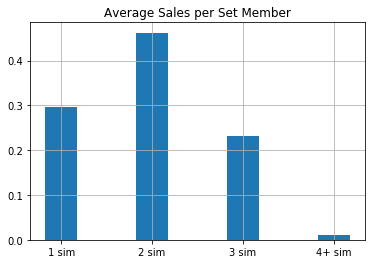

In [46]:
ind = np.arange(4)
width = 0.35
plt.grid(True)
plt.bar(ind + width, percentages, width)
plt.xticks(ind+width, ('1 sim', '2 sim', '3 sim', '4+ sim'))
plt.title('Average Sales per Set Member')
plt.show()

In [47]:
percentages

[0.29535398230088494,
 0.46199431099873578,
 0.23245891276864727,
 0.010192793931731985]

The plot below shows the functions to generate the number of digital interactions per customer (left) and the actual generated number of digital interactions per customer.

In [ ]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfNonCarLoaners(x), label = 'Other Digitals')
ax1.plot(x, numberOfTotalDigitals(x), label = 'Total Digitals ')
ax2.plot(approvals.dayOfYear, approvals.dig, ',', label='Other Digits')
ax2.plot(approvals.dayOfYear, approvals.itx + approvals.sim + approvals.dig, ',', label='Total Digits')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Number of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

## 3.4 Branch Interactions

Below, some of the branch interactions are shown for illustration.

In [50]:
branchfile = 'ItxData_CarBranch_2016-10-30_2017-04-30.csv'
names = pd.read_csv(basepath + 'ItxData_CarBranch_2016-10-30_2017-04-30.hdr', sep=';')
branches = pd.read_csv(basepath + branchfile, sep=';', names=names)
branches.loc[:,'date'] = branches.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
branches.loc[:,'time'] = branches.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
branches['dayOfYear'] = branches.date.map(lambda x: int(x.strftime('%j')) - 1)

In [51]:
print(len(branches))
branches.head()

30785


,id,date,time,goal,subgoal,channel,contrToSuccessDefs,dayOfYear
0,2,2014-12-21,21:52:40.778724,consume info,request information,branch,car loan sale,354
1,2,2014-12-05,09:35:59.499269,consume info,request information,branch,car loan sale,338
2,10,2015-02-04,10:28:39.809442,consume info,request information,branch,car loan sale,34
3,10,2015-02-02,14:47:18.861879,consume info,request information,branch,car loan sale,32
4,10,2015-01-25,16:06:14.192905,consume info,request information,branch,car loan sale,24


In [52]:
def numberOfBranches(x):
    return logit(x, position=0.5, spread=100, setoff=1.25, altitude=1.25)

In [53]:
numberOfBra = pd.DataFrame(branches.groupby(['id']).size(), columns=['bra'])
approvals = pd.merge(precampaign, numberOfBra, left_on='id', right_index=True, how='left')
approvals.bra = approvals.bra.apply(lambda x: 0 if np.isnan(x) else x)

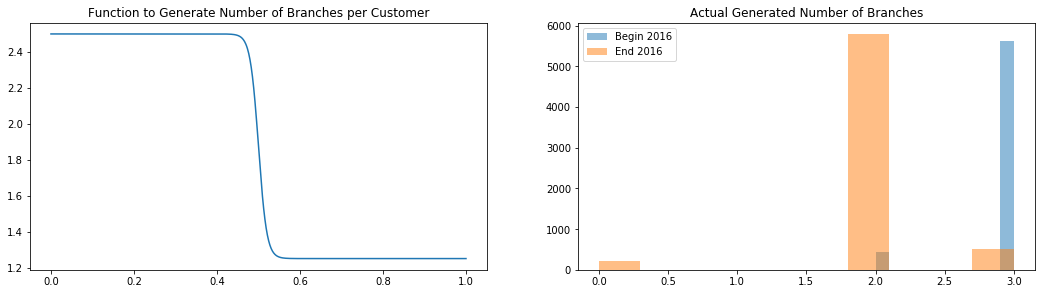

In [54]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
pre2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 < 182)].bra
post2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 > 183)].bra
ax1.plot(x, numberOfBranches(x))
ax2.hist(pre2016, alpha=0.5, label='Begin 2016');ax2.hist(post2016, alpha=0.5, label='End 2016')
ax1.set_title('Function to Generate Number of Branches per Customer')
ax2.set_title('Actual Generated Number of Branches'); ax2.legend()
plt.show()

## 3.5 Call Center Interactions

In [55]:
callcenterfile = 'ItxData_CarCallCenter_2016-10-30_2017-04-30.csv'
names = pd.read_csv(basepath+'ItxData_CarCallCenter_2016-10-30_2017-04-30.hdr', sep=';')
callcenters = pd.read_csv(basepath+callcenterfile, sep=';', names=names)
callcenters.loc[:,'date'] = callcenters.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
callcenters.loc[:,'time'] = callcenters.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
callcenters['dayOfYear'] = callcenters.date.map(lambda x: int(x.strftime('%j')) - 1)

In [56]:
print(len(callcenters))
callcenters.head()

24670


,id,date,time,goal,subgoal,channel,contrToSuccessDefs,dayOfYear
0,2,2014-12-14,08:40:35.362197,consume info,request information,call center,car loan sale,347
1,2,2014-11-30,11:39:50.663501,consume info,request information,call center,car loan sale,333
2,10,2015-02-01,11:01:03.794646,consume info,request information,call center,car loan sale,31
3,10,2015-02-12,12:05:58.145258,consume info,request information,call center,car loan sale,42
4,11,2015-11-10,17:39:21.826698,consume info,request information,call center,car loan sale,313


In [57]:
def numberOfCallCenters(x):
    return logit(x, position=0.5, spread=100, setoff=1.25, altitude=0.25)

In [58]:
numberOfCal = pd.DataFrame(callcenters.groupby(['id']).size(), columns=['cal'])
approvals = pd.merge(precampaign, numberOfCal, left_on='id', right_index=True, how='left')
approvals.cal = approvals.cal.apply(lambda x: 0 if np.isnan(x) else x)

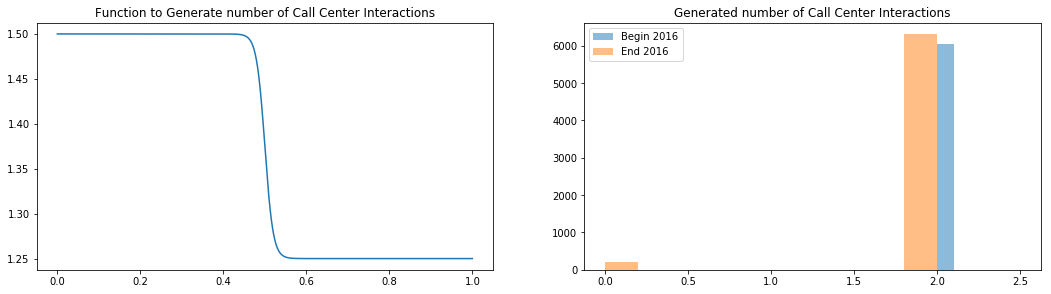

In [59]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
pre2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 < 182)].cal
post2016 = approvals[approvals.date.map(lambda x: int(x.strftime('%j')) - 1 > 183)].cal
ax1.plot(x, numberOfCallCenters(x))
ax2.hist(pre2016, alpha=0.5, label='Begin 2016');ax2.hist(post2016, alpha=0.5, label='End 2016')
ax1.set_title('Function to Generate number of Call Center Interactions')
ax2.set_title('Generated number of Call Center Interactions'); ax2.legend()
plt.show()

# 4. Attribution

In [60]:
janData = (precampaign[precampaign.date.map(lambda x: x.month == 1 and x.year == 2016)])
febData = (precampaign[precampaign.date.map(lambda x: x.month == 2 and x.year == 2016)])
marData = (precampaign[precampaign.date.map(lambda x: x.month == 3 and x.year == 2016)])
aprData = (precampaign[precampaign.date.map(lambda x: x.month == 4 and x.year == 2016)])
mayData = (precampaign[precampaign.date.map(lambda x: x.month == 5 and x.year == 2016)])
junData = (precampaign[precampaign.date.map(lambda x: x.month == 6 and x.year == 2016)])
julData = (precampaign[precampaign.date.map(lambda x: x.month == 7 and x.year == 2016)])
augData = (precampaign[precampaign.date.map(lambda x: x.month == 8 and x.year == 2016)])
sepData = (precampaign[precampaign.date.map(lambda x: x.month == 9 and x.year == 2016)])
octData = (precampaign[precampaign.date.map(lambda x: x.month == 10 and x.year == 2016)])
novData = (precampaign[precampaign.date.map(lambda x: x.month == 11 and x.year == 2016)])
decData = (precampaign[precampaign.date.map(lambda x: x.month == 12 and x.year == 2016)])
janData.head()

,id,date,time,goal,subgoal,channel,simulationType,simulationLoanAmount,simulationDownPayment,simulationMonthlyPayment,simulationPaymentRate,simulationDuration,simulationTradeInValue,simulationCashRebate,currentPageId,bannerId,successDef,dayOfYear
550,637,2016-01-28,17:49:29.429631,request information,approval,branch,car loan,44357,781,406,4,55,3000,0,NaN,NaN,car loan sale,27
937,1130,2016-01-06,07:32:54.990957,request information,approval,branch,car loan,71691,446,496,3,55,3000,0,NaN,NaN,car loan sale,5
967,1180,2016-01-15,03:26:01.412652,request information,approval,call center,car loan,58534,467,509,2,52,3000,0,NaN,NaN,car loan sale,14
1205,1472,2016-01-14,20:31:04.595046,request information,approval,branch,car loan,45878,504,700,4,47,3000,0,NaN,NaN,car loan sale,13
1269,1547,2016-01-16,06:25:48.512575,request information,approval,branch,car loan,77961,543,629,2,57,3000,0,NaN,NaN,car loan sale,15


## Last Touchpoint

In [64]:
channels = ['web', 'branch', 'call center']
janValues = [np.mean(janData.channel == c) for c in channels]
febValues = [np.mean(febData.channel == c) for c in channels]
marValues = [np.mean(marData.channel == c) for c in channels]
aprValues = [np.mean(aprData.channel == c) for c in channels]
mayValues = [np.mean(mayData.channel == c) for c in channels]
junValues = [np.mean(junData.channel == c) for c in channels]
julValues = [np.mean(julData.channel == c) for c in channels]
augValues = [np.mean(augData.channel == c) for c in channels]
sepValues = [np.mean(sepData.channel == c) for c in channels]
octValues = [np.mean(octData.channel == c) for c in channels]
novValues = [np.mean(novData.channel == c) for c in channels]
decValues = [np.mean(decData.channel == c) for c in channels]

In [65]:
print janValues
print febValues
print marValues
print aprValues
print mayValues
print junValues
print julValues
print augValues
print sepValues
print octValues
print novValues
print decValues

[0.063492063492063489, 0.66666666666666663, 0.26984126984126983]
[0.058823529411764705, 0.77058823529411768, 0.17058823529411765]
[0.065573770491803282, 0.65027322404371579, 0.28415300546448086]
[0.028708133971291867, 0.68899521531100483, 0.28229665071770332]
[0.069306930693069313, 0.62376237623762376, 0.30693069306930693]
[0.068062827225130892, 0.61780104712041883, 0.31413612565445026]
[0.10309278350515463, 0.57216494845360821, 0.32474226804123713]
[0.079545454545454544, 0.61363636363636365, 0.30681818181818182]
[0.084905660377358486, 0.61792452830188682, 0.29716981132075471]
[0.15555555555555556, 0.56666666666666665, 0.27777777777777779]
[0.064171122994652413, 0.65240641711229952, 0.28342245989304815]
[0.083756345177664976, 0.63451776649746194, 0.28172588832487311]


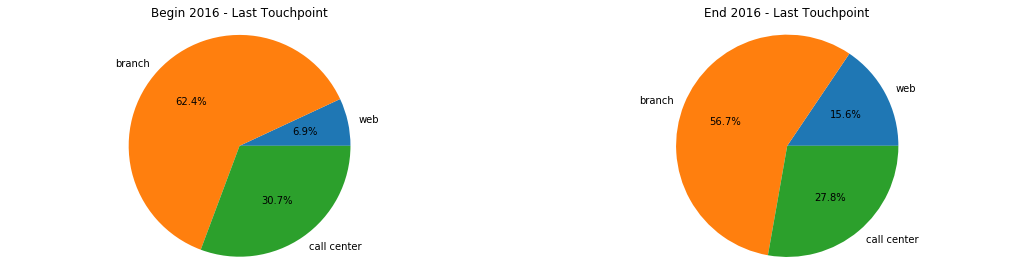

In [69]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(mayValues, labels=channels, autopct='%1.1f%%')
ax2.pie(octValues, labels=channels, autopct='%1.1f%%')
ax1.set_title('Begin 2016 - Last Touchpoint')
ax2.set_title('End 2016 - Last Touchpoint')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

## Linear

How much branch and call center interactions to generate.

In [80]:
weights = {'web':0.01, 'call':0.2, 'branch':0.4}

# Begin 2016
web1 = 22 * weights['web'] # 20 page visits + 2 simulaties
bra1 = 2.5 * weights['branch']
cal1 = 1.5 * weights['call']

# End 2016
web2 = 33 * weights['web'] # 30 page visits + 3 simulaties
bra2 = 1.25 * weights['branch']
cal2 = 1.25 * weights['call']

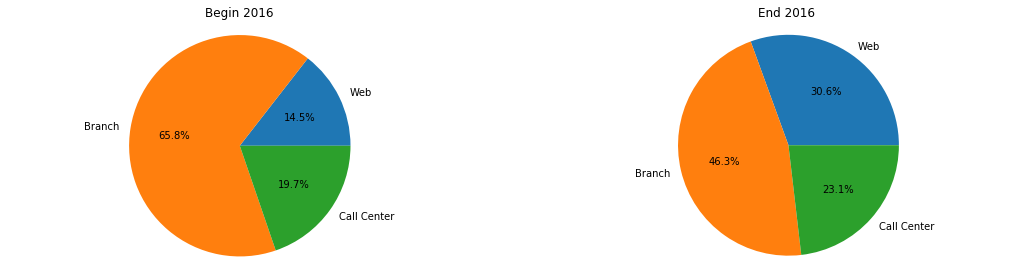

In [81]:
channels = ['Web', 'Branch', 'Call Center']
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(np.array([web1, bra1, cal1])*10, labels=channels, autopct='%1.1f%%')
ax2.pie(np.array([web2, bra2, cal2])*10, labels=channels, autopct='%1.1f%%')
ax1.set_title('Begin 2016')
ax2.set_title('End 2016')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

In [72]:
def linearAttribution(succesEvent, weights = {'web':0.01, 'call':0.2, 'branch':0.4}):
    customer = succesEvent.id
    
    # 60 days contribution window
    endDate = succesEvent.date.date()
    startDate = endDate + timedelta(days = -60)
    
    # Get number of contributions in window per channel
    nrCalls = sum((callcenters.date <= endDate) & (callcenters.date > startDate) & (callcenters.id == customer))
    nrBranch = sum((branches.date <= endDate) & (branches.date > startDate) & (branches.id == customer))
    nrSim = sum((presim.date <= endDate) & (presim.date > startDate) & (presim.id == customer))
    nrPage = sum((prepag.date <= endDate) & (prepag.date > startDate) & (prepag.id == customer))
    
    # Calculate channel attribution
    total = (nrSim + nrPage) * weights['web'] + nrCalls * weights['call'] + nrBranch * weights['branch']
    webContr = ((nrSim+nrPage) * weights['web']) / total
    branchContr = (nrBranch * weights['branch']) / total   
    callContr = (nrCalls * weights['call']) / total

    return pd.Series([webContr, branchContr, callContr])

In [73]:
janContributions = janData.apply(lambda x: linearAttribution(x), axis=1)
febContributions = febData.apply(lambda x: linearAttribution(x), axis=1)
marContributions = marData.apply(lambda x: linearAttribution(x), axis=1)
aprContributions = aprData.apply(lambda x: linearAttribution(x), axis=1)
mayContributions = mayData.apply(lambda x: linearAttribution(x), axis=1)
junContributions = junData.apply(lambda x: linearAttribution(x), axis=1)
julContributions = julData.apply(lambda x: linearAttribution(x), axis=1)
augContributions = augData.apply(lambda x: linearAttribution(x), axis=1)
sepContributions = sepData.apply(lambda x: linearAttribution(x), axis=1)
octContributions = octData.apply(lambda x: linearAttribution(x), axis=1)
novContributions = novData.apply(lambda x: linearAttribution(x), axis=1)
decContributions = decData.apply(lambda x: linearAttribution(x), axis=1)
janContributions.head()

,0,1,2
550,1.000000,0.000000,0.000000
937,0.238095,0.380952,0.380952
967,0.154930,0.563380,0.281690
1205,0.473684,0.000000,0.526316
1269,0.272727,0.727273,0.000000


In [75]:
janValues = janContributions.apply(np.mean, axis=0).values
febValues = febContributions.apply(np.mean, axis=0).values
marValues = marContributions.apply(np.mean, axis=0).values
aprValues = aprContributions.apply(np.mean, axis=0).values
mayValues = mayContributions.apply(np.mean, axis=0).values
junValues = junContributions.apply(np.mean, axis=0).values
julValues = julContributions.apply(np.mean, axis=0).values
augValues = augContributions.apply(np.mean, axis=0).values
sepValues = sepContributions.apply(np.mean, axis=0).values
octValues = octContributions.apply(np.mean, axis=0).values
novValues = novContributions.apply(np.mean, axis=0).values
decValues = decContributions.apply(np.mean, axis=0).values

In [76]:
print janValues
print febValues
print marValues
print aprValues
print mayValues
print junValues
print julValues
print augValues
print sepValues
print octValues
print novValues
print decValues

[ 0.28833882  0.51372903  0.19793215]
[ 0.3020249   0.52209183  0.17588328]
[ 0.32044697  0.48888649  0.19066654]
[ 0.29229423  0.52487768  0.1828281 ]
[ 0.27512849  0.51352398  0.21134753]
[ 0.32335835  0.46329448  0.21334717]
[ 0.37140222  0.39856427  0.2300335 ]
[ 0.40410541  0.38981074  0.20608385]
[ 0.40581252  0.37231408  0.2218734 ]
[ 0.37784827  0.39495379  0.22719793]
[ 0.42516929  0.35996314  0.21486758]
[ 0.81379301  0.11877002  0.06743697]


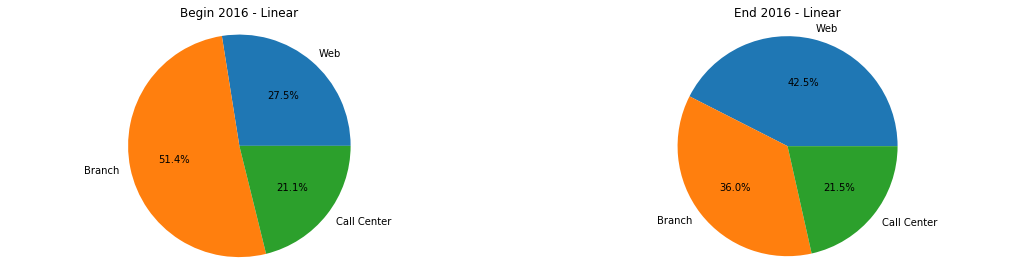

In [77]:
channels = ['Web', 'Branch', 'Call Center']
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(mayValues, labels=channels, autopct='%1.1f%%')
ax2.pie(novValues, labels=channels, autopct='%1.1f%%')
ax1.set_title('Begin 2016 - Linear')
ax2.set_title('End 2016 - Linear')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

# 5. Data Ingest in Lily

## Data on Cluster

Csv files on cluster are identical.

## Dataframe in Lily

Print out first rows of dataframe.

In [ ]:
basepath = '/Users/desiredewaele/Desktop/Car Loan Test 2016/'
names = pd.read_csv(basepath+'dataframe_columns.csv', sep='|')
data = pd.read_csv(basepath+'dataframe.csv', sep='|', names=names.name)
data.head(10)

3 customer ids in dataframe

In [ ]:
data[data.originalSourceIds.isin(['[""CRM:6""]', '[""CRM:9937""]', '[""CRM:49458""]'])]

same 3 customerids in product table

In [ ]:
productData[(productData.PRODUCT == 'Car Loan') & (productData.ID.isin([6, 9937, 49458]))]

In [ ]:
len(data[-np.isnan(data.marginCarLoans)]), len(productData[(productData.PRODUCT == 'Car Loan')])

Compare means (excluding non-nan's) with expected values according to functions above. These behave as expected.

In [ ]:
timeX = 2484 / (7.*365) # Normalized day number of 2016-10-20
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)

In [ ]:
plt.pie(data.remainingYearsCarLoan.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Compare means (including non-nan's with default value 0) with expected values according to functions above. These numbers are shown by the Lily widgets.

In [ ]:
data.marginCarLoans = data.marginCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.rateCarLoans = data.rateCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.valueCarLoans = data.valueCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.creditCarLoans = data.creditCarLoans.apply(lambda x: 0 if np.isnan(x) else x)

In [ ]:
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)